# Testing Notebook

### Imports and Data Input

[]


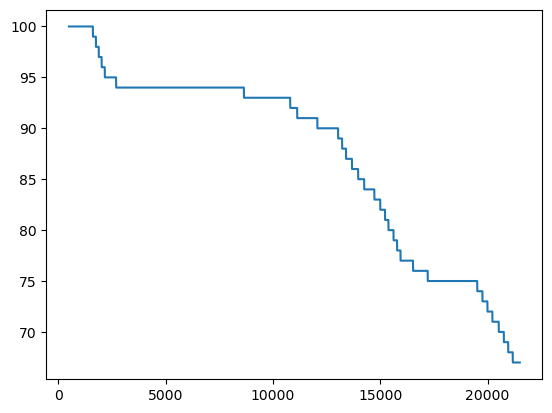

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import time

"""Import Data"""
file = "data/L230218.CSV"
df = pd.read_csv(file)

header_ind = df[df['Lat']=='Lat'].index.tolist()
print(header_ind)

df = df[500:21500]
for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col])
plt.plot(df.index,df['SOC 1 %'])

### Data Cleaning and Organization

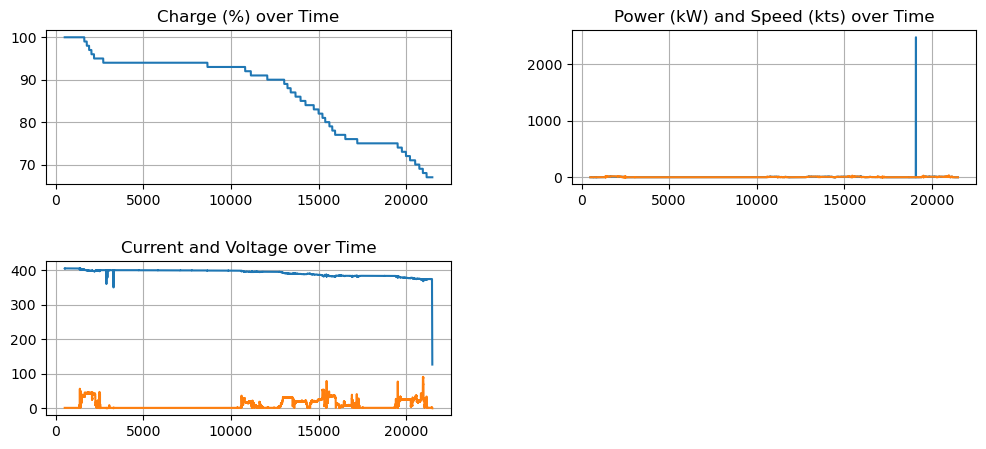

In [2]:
"""Format and clean test data:"""
# Extracting columns simplifies the database for visual purposes.
# It will eventually be extraneous.
columns = ['Date', 'Time', 'Lat', 'Lon', 'Speed m/s', 'Distance km',
        'RPM 1', 'Motor Load 1 %', 'Motor Torque 1 %', 'Motor Temp 1 C',
        'Pack Current 1 A', 'Pack Voltage 1 V', 'Pack Temp 1 C', 'SOC 1 %',
        ## 'Battery Health', 'Water Speed'
        ]
df = df[columns]

'''Create new calculated columns'''
df['Pack Voltage 1 V'] = df['Pack Voltage 1 V']*10
df['Power 1 kW'] = df['Pack Current 1 A']*df['Pack Voltage 1 V']/1000
df['Distance nm'] = df['Distance km']*0.539957
df['Speed kts'] = df['Speed m/s']*1.944

'''Adjust time format'''
tFMT = "%H:%M:%S"
df['Time'] = pd.to_datetime(df['Time'], format=tFMT)

'''Theo's time adjustment'''
# df.Time = (pd.to_datetime(df['Time'].str.strip(), format = '%H:%M:%S'))
# adjusted_time = np.array(0)
# x = 0
# for i in range(len(df.Time)):
#     if i+1 >= len(df.Time):
#         break
#     x += (df.Time[i+1] - df.Time[i]).total_seconds()
#     adjusted_time = np.append(adjusted_time,x)
# df['Time'] = adjusted_time.astype(float)

'''Remove Outliers'''
# high_charge = df[df['SOC 1 %']>100].index.tolist()
# low_charge = df[df['SOC 1 %']<3].index.tolist()
# bogus_battery = high_charge+low_charge
# df.drop(bogus_battery, inplace=True)         # Drop rows with bogus battery values

'''Interesting Plots'''
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(df.index, df['SOC 1 %'])
plt.grid()
plt.title('Charge (%) over Time')

plt.subplot(2,2,2)
plt.plot(df.index, df['Speed kts'], df['Power 1 kW'])
plt.grid()
plt.title('Power (kW) and Speed (kts) over Time')

plt.subplot(2,2,3)
plt.plot(df.index, df['Pack Voltage 1 V'], df['Pack Current 1 A'])
plt.grid()
plt.title('Current and Voltage over Time')

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.3)

### Define Algorithms

In [3]:
"""
Define algorithms to be called during testing loop:
    -Overall Avg
    -Rolling Avg
    -ML model
    """

"""Initial Consumption Calculation"""
"""Calculate average kWh/nm for entire run.
Will be removed."""

df = df[11000:14500]

batt_cap = 63   # kWh
batt_health = 1.00 # %
batt_full = batt_cap*batt_health


df['Coulombs Remain'] = df['SOC 1 %']*batt_cap/df['Pack Voltage 1 V']*1000*3600

batt_consumed = (df['SOC 1 %'].iloc[0] - df['SOC 1 %'].iloc[-1])*batt_full/100   # kWh
dist_traveled = (df['Distance nm'].iloc[-1] - df['Distance nm'].iloc[0])  # nm
time_spent = df['Time'].iloc[-1] - df['Time'].iloc[0]

avg_consumption_rate = batt_consumed/dist_traveled

print('Run Stats:', round(time_spent.seconds/60, 1), 'min |', round(dist_traveled, 2), 'nm traveled |', batt_consumed, 'kWh spent')
print('Avg kW:', round(df['Power 1 kW'].mean(), 1), 'kW | kWh/time', round(batt_consumed/(time_spent.seconds/3600),1), 'kW | kWh/dist', round(batt_consumed/dist_traveled,1), 'kWh/nm | kW/speed', round(df['Power 1 kW'].mean()*1852/(df['Speed m/s'].mean()*3600),1),'kWh/nm')

Run Stats: 58.8 min | 3.01 nm traveled | 5.67 kWh spent
Avg kW: 5.4 kW | kWh/time 5.8 kW | kWh/dist 1.9 kWh/nm | kW/speed 0.9 kWh/nm


In [4]:
def rolling_avg(data, batt_cap, N):
    """This function is based on a rolling average consumption rate of N data points.
    Any consumption rates that are not valid, or within the first N data points of the run,
    will default to using the stored average consumption rate."""

    dist_list = []

    cached_avg = avg_consumption_rate       # need a cached average value to default to 
    for i in range(len(data)):
        batt = data['SOC 1 %'].iloc[i]*batt_cap/100
        roll_batt_consumed = (data['SOC 1 %'].iloc[i-N] - data['SOC 1 %'].iloc[i])*batt_full/100          #kWh
        roll_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[i-N])                  #nm
        roll_consumption = roll_batt_consumed/roll_dist_traveled                                            #kWh/nm
        
        if i < N or roll_consumption==0:
            dist_remaining = batt/cached_avg      # This will need to change because we won't know the average with real-time data
            print('%d Consumption Rate: %.2f kWh/nm | Dist Remaining %.1f nm' % (i, cached_avg, dist_remaining), end=' \r')
            # time.sleep(0.001)
        else:
            dist_remaining = batt/roll_consumption   #nm
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining: %.2f nm' % (i, batt, roll_consumption, dist_remaining), end=' \r')
            # time.sleep(.001)

        dist_list.append(dist_remaining)

    return dist_list


def overall_avg(data, batt_cap):
    """This function is based on an overall average of all the data in the trip.
    Takes in a dataframe from the vessel and the capacity of the battery."""

    dist_list = []

    for i in range(len(data)):
        batt = data['SOC 1 %%'].iloc[i]*batt_cap/100
        avg_batt_consumed = (data['SOC 1 %'].iloc[0] - data['SOC 1 %'].iloc[i])*batt_full/100          #kWh
        avg_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[0])                  #nm
        avg_consumption = avg_batt_consumed/avg_dist_traveled

        dist_remaining = batt/avg_consumption

        dist_list.append(dist_remaining)

    return dist_list


def update_average():
    """This is a function to update the stored average consumption of the vessel."""

    pass


### Testing Loop

TypeError: cannot perform __truediv__ with this index type: DatetimeArray

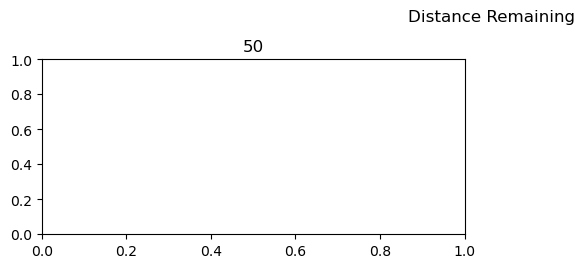

In [5]:
"""
Testing Loop:
    -Loop through CSV rows and update estimated mileage on each iteration
    -Call functions within test loop
    -Nest loops if there are multiple runs or multiple parameters to compare
    -Plot interesting data (R to L):
        --Distance Remaining over time
    -Different runs / parameters (Top Down)
"""

plt.figure(figsize = (12,5))
plt.suptitle('Distance Remaining')

Nlist = [50, 100, 500, 1000]
rolling_distances = []
# cached_avg = avg_consumption_rate    # This will need to be a locally stored value based on historical data. We want this to be conservative.
for N in Nlist:

    dist_list = rolling_avg(df, 63, N)
    rolling_distances.append(dist_list)

    n = Nlist.index(N)
    plt.subplot(2,2,n+1)
    plt.title(N)
    plt.plot(df['Time']/60, rolling_distances[n])
    plt.xlabel("Time (mins)")
    plt.ylabel('Distance Remaining (nm)')

    plt.subplots_adjust(hspace = 0.5)
    plt.subplots_adjust(wspace = 0.3)

plt.tight_layout()


In [ ]:
"""Test Loop for Plot: An attempt to plot time versus distance remaining, 
   calculated every 10 seconds in order to smooth final curve.
   Currently not yet working, running into error of 'Output exceeds the 
   size limit. Open the full output data in a text editor'. I am inclined 
   to believe that matplotlib has trouble processing datetime format of the 
   'Time' column. 
"""
sample_list = [1,10,20,30,40,50,60]
distances = []
time0 = [] 
for N in sample_list:
    distanceList = [] 
    time1 = []
    count = 0
    for i in range(len(df)):
        batt = df['SOC 1 %%'].iloc[i]*batt_cap/100        # Change into kWh based on 63 kWh full charge
        dist = batt/avg_consumption_rate            # In km. Will eventually need to be nm
        print('Battery Remaining = %.1f kWh | Distance Remaining = %.1f nm' % (batt, dist), end=' \r')
        # time.sleep(.001)
        count += 1
        if count % N == 0:
            time2 = df['Time'].iloc[i]    #fixed it here, "Only append the current time value"
            time1.append(time2)
            distanceList.append(dist)

    distances.append(distanceList)
    time0.append(time1)

plt.figure(figsize = (17,34))
plt.suptitle('Distance Remaining in Nautical Miles Over the Course of Trip', y=1) 

index = 1
for i in range (0,7):
    plt.subplot(7,2,index)
    index +=1
    plt.title(f'int = {sample_list[i]}')
    plt.plot(time0[i], distances[i])
    space = np.array(range(0,int(np.max(time0[i])),200))
    plt.xticks(space,labels = np.round(space/60,0))
    plt.xlabel("Time (mins)")
    plt.ylabel('Distance Remaining (nm)')

    plt.subplots_adjust(hspace = 0.5)

    #Smooth line version of graph 
    plt.subplot(7,2,index)
    index+=1 
    x_smooth = np.linspace(np.min(time0[i]),np.max(time0[i]),num = 25) #Num represents number of points, play around to affect smoothness
    bspline = interpolate.make_interp_spline(time0[i], distances[i])
    y_smooth = bspline(x_smooth)
    plt.title(f'Smoothing: int = {sample_list[i]}')
    plt.plot(x_smooth,y_smooth)
    plt.xticks(space,labels = np.round(space/60,0))
    plt.xlabel("Time (mins)")
    plt.ylabel('Distance Remaining (nm)')
    plt.subplots_adjust(wspace = 0.3)

plt.tight_layout()